In [3]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import numpy as np
from einops import rearrange, repeat
from torch import einsum

In [4]:
class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

torch.Size([5, 9, 94, 32, 64]) dots

In [5]:
dots = torch.randn(5, 9, 94, 32, 64)

In [6]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    return chunk_grid

In [7]:
ChunkGrid(3008, 32)

tensor([[ 0,  0,  0,  ..., 93, 93, 93],
        [ 1,  1,  1,  ..., 92, 92, 92],
        [ 2,  2,  2,  ..., 91, 91, 91],
        ...,
        [91, 91, 91,  ...,  2,  2,  2],
        [92, 92, 92,  ...,  1,  1,  1],
        [93, 93, 93,  ...,  0,  0,  0]])

In [8]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    return chunk_grid

In [9]:
chunkgrid = ChunkGrid(4800, 48)
pareto = torch.distributions.pareto.Pareto(torch.tensor(3.0), torch.tensor(2.0)).sample(chunkgrid.shape)
chunkgrid = chunkgrid - pareto

column = 0
print(chunkgrid[column].topk(384, largest=False).indices.max())
chunkgrid[column].topk(200, largest=False).indices.sort(-1).values

tensor(3847)


tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
          61,   63,   64,   65,   67,   68,   69,   70,   71,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
          89,   90,   92,   93,   95,   99,  101,  103,  105,  106,  109,  111,
         128,  129,  131,  132,  135,  137,  139,  140,  143,  146,  147,  148,
         149,  151,  152,  156,  161,  163,  165,  171,  176,  177,  180,  181,
         183,  186,  188,  189,  197,  198,  201,  214,  216,  222,  228,  231,
         232,  240,  243,  244,  247,  253,  254,  268,  269,  275,  276,  279,
         290,  291,  308,  317,  331,  3

In [10]:
chunkgrid.shape

torch.Size([100, 4800])

In [11]:
from matplotlib import pyplot as plt

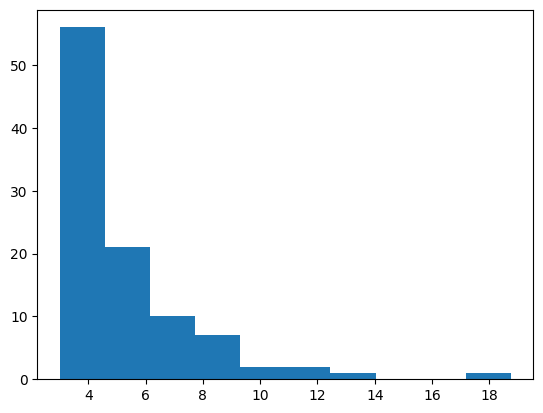

tensor([ 3.0097,  3.0432,  3.0915,  3.1019,  3.1028,  3.1398,  3.1784,  3.1840,
         3.1873,  3.2184,  3.2200,  3.2216,  3.2373,  3.2410,  3.2466,  3.2763,
         3.2913,  3.2934,  3.3168,  3.3351,  3.3378,  3.3578,  3.4119,  3.4313,
         3.4581,  3.4597,  3.4775,  3.4794,  3.4946,  3.5376,  3.5586,  3.5749,
         3.6269,  3.6638,  3.7310,  3.8028,  3.8267,  3.8380,  3.8780,  3.8874,
         3.8957,  3.9028,  3.9122,  3.9925,  4.1036,  4.1047,  4.1234,  4.1829,
         4.2224,  4.2514,  4.3246,  4.4109,  4.4347,  4.4368,  4.5100,  4.5780,
         4.6048,  4.6141,  4.6461,  4.6887,  4.7531,  4.8639,  4.9481,  5.0410,
         5.0525,  5.1421,  5.2515,  5.2779,  5.2822,  5.2838,  5.3425,  5.5370,
         5.5552,  5.8407,  5.8487,  5.8869,  5.9556,  6.1609,  6.2159,  6.4114,
         6.8111,  6.9793,  7.0003,  7.3768,  7.3914,  7.5698,  7.5836,  7.9328,
         8.1207,  8.3174,  8.5855,  8.7896,  8.8310,  9.0010,  9.4844,  9.7659,
        11.1205, 12.4118, 12.7426, 18.74

In [12]:
dist = torch.distributions.pareto.Pareto(3, 2).sample(torch.tensor([100]))
plt.hist(dist)
plt.show()
print(dist.sort(-1).values)

In [13]:
print(chunkgrid[0].topk(40, largest=False).indices.max())
chunkgrid[0].topk(40, largest=False).indices.sort(-1).values


tensor(3847)


tensor([  12,   25,   28,   30,   57,   59,  132,  156,  161,  163,  198,  222,
         228,  243,  268,  279,  348,  349,  350,  497,  530,  550,  554,  555,
         656,  698,  725,  738,  795,  817,  838,  936, 1321, 1630, 1691, 2571,
        2652, 2998, 3417, 3847])

In [205]:
torch.ones(3, 3).triu(1).bool().repeat_interleave(3, dim=1)

tensor([[False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False]])

In [614]:
def exists(val):
    return val is not None

class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

class MyopicAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.0,
        max_keep_keys=50,
        chunk_window=3,
        bias=True,
        return_attention=False,
        causal=False,
    ):
        super().__init__()
        self.n_feats = n_feats
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.bias = bias
        self.return_attention = return_attention

        self.causal = causal

        self.scale = head_dim ** -0.5

        self.max_keep_keys = max_keep_keys
        self.W = chunk_window

        self.positional_bias = DynamicPositionBias(
            dim = n_feats,
            heads = n_heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

    def pad_to_window_size(self, x, window_size, axis=3, mask=None):
        """
        Pad the input on two sides to be divisible by `window_size`
        """
        QKV, batch_size, heads, sequence_length, hidden_size = x.shape
        padding_length = (window_size - sequence_length % window_size) % window_size
        padding = torch.zeros(QKV, batch_size, heads, padding_length, hidden_size,
            device=x.device,
            dtype=x.dtype,
        )
        mask = F.pad(mask, (0, padding_length), value=True) 
        return torch.cat([x, padding], axis=axis), padding_length, mask

    def unpad(self, x, padding_length):
        """
        Undo padding.
        """
        if padding_length > 0:
            return x[:, :-padding_length]
        return x

    def ChunkGrid(self, Total_Size, Block_Size):
        Psize = Total_Size // Block_Size
        chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
        #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)) # don't normalize cus it'll stretch the distribution by sequence length
        return chunk_grid    

    def causal_windowed_mask(self, window_number, window_size, device):
        '''
        Create a block diagonal causal mask, to prevent selecting future tokens in the topk key selection
        '''
        return torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)

    def standard_forward(self, qkv, mask):
        query, key, value = qkv
        dots = torch.einsum('bhid,bhjd->bhij', query, key) * self.scale
        positions = self.positional_bias(dots.shape[-1], device=dots.device, dtype=dots.dtype)
        dots += positions
        attn_mask = rearrange(mask, "b n -> b () n ()") * rearrange(mask, "b n -> b () () n")
    
        if self.causal:
            # create a regular causal mask
            causal_mask = torch.ones(dots.shape[-2], dots.shape[-1], device=dots.device).triu(1).bool()
            attn_mask = torch.logical_or(attn_mask, causal_mask)

        
        dots.masked_fill_(attn_mask, -torch.finfo(dots.dtype).max)
    
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, value)
        return out


    def forward(self, x, mask, return_attention=False):
        assert mask is not None, 'pls wear a mask'
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim

        tokeep = min(self.max_keep_keys, N) if self.max_keep_keys != -1 else N # number of keys to keep
        W = min(self.W, N) if self.W != -1 else N # window size

        qkv = rearrange(self.qkv_proj(x), "b n (h d qkv) -> qkv b h n d", qkv=3, h=H, d=D) # qkv projection

        qkv, pad_n, mask = self.pad_to_window_size(qkv, W, axis=3, mask=mask) # add padding so it's divisible by W
        q, kv = qkv[0], qkv[1:] # separate q and kv, we keep kv together for now as we apply the same operations to both
        
        q = rearrange(q, "b h (n w) d -> b h n w d", w=W)# split q into windows/chunks of size W
      
        q_mask = repeat(rearrange(mask, "b (n w) -> b n w", w=W), "b n w -> b h n w", h=H) # do the same for the mask
            
        kv = repeat(kv, "kv b h n d -> kv b h nw n d", nw=q.shape[2]) # duplicate k and v for total number of windows
        #print(q.shape, kv.shape)
        KV, B, H, NW, N, D = kv.shape

        chunkgrid = self.ChunkGrid(Total_Size=N, Block_Size=W).to(q.device)
        chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous()

        SCALE = torch.tensor(3.0, device=q.device, dtype=q.dtype)
        ALPHA = torch.tensor(2.0, device=q.device, dtype=q.dtype)
        pareto_dist = torch.distributions.pareto.Pareto(SCALE, ALPHA).sample(chunkgrid.shape).to(q.device)
        chunkgrid = chunkgrid - pareto_dist

        chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

        cmask = repeat(mask, 'b n -> kv b h nw n', kv=2, h=H, nw=NW)

        if self.causal:
            causal_mask = self.causal_windowed_mask(window_number=NW, window_size=W, device=q.device)
            cmask = torch.logical_or(cmask, causal_mask)
        
        chunkgrid = chunkgrid.masked_fill(cmask, torch.finfo(q.dtype).max) # max cus we topk in reverse order 

        keep_indices = chunkgrid.topk(k=tokeep, dim=-1, sorted=False, largest=False).indices.sort(dim=-1).values
        KV, B, H, NW, N, D = kv.shape 
        kv = kv.gather(-2, repeat(keep_indices, "kv b h w n -> kv b h w n d", d=D))

        kv_mask = repeat(mask, "b n -> b h nw n", h=H, nw=NW)
     
        kv_mask = kv_mask.gather(-1, keep_indices[0])

        k, v = kv
        # nw (number of windows) = p (in the einsum below)
        dots = einsum("b h n p d, b h n z d -> b h n p z ", q, k) * self.scale # Z is number of chunks in Q, N is max sequence length after dropping
        print(dots.shape)
        ## positional stuff
        pos_bias = self.positional_bias(N, device=dots.device, dtype=dots.dtype)
        pos_bias = repeat(pos_bias, 'h i j -> b h i j', b = B)
        pos_bias = rearrange(pos_bias, 'b h (n w) j -> b h n w j', w = W)

        keep_indices = repeat(keep_indices, "kv b h nw n -> kv b h nw w n", w=W)[0] 
        pos_bias = pos_bias.gather(-1, keep_indices)
        
        dots = dots + pos_bias

        mask_val = -torch.finfo(dots.dtype).max
        
        qk_mask = rearrange(q_mask, "b h n w -> b h n w ()") * rearrange(kv_mask, "b h w n -> b h w () n")

        if self.causal:
            causal_mask = keep_indices > rearrange(torch.arange(0, N, device=q.device), "(nw w) -> w nw ()", w=NW, nw=W)
            qk_mask = torch.logical_or(qk_mask, causal_mask)
    
        dots.masked_fill_(qk_mask, mask_val)
      
        #print(dots.shape)
        attn = dots.softmax(dim=-1)
        print(attn.shape)

        normal_attn = self.standard_forward(qkv=qkv, mask=mask)
        normal_attn = rearrange(normal_attn, "b h n d -> b n (h d)")
     

        out = einsum("b h n w z, b h n z d -> b h n w d", attn, v) 
        print(attn.shape, v.shape, out.shape)

        out = rearrange(out, "b h n w d -> b (n w) (h d)")
        return out, normal_attn
        
        out = self.unpad(out, pad_n)
        
        out = self.out_proj(out)
     
        return out if not return_attention else (out, attn)

In [615]:
attention = MyopicAttention(n_feats=216, head_dim=24, n_heads=12, max_keep_keys=-1, chunk_window=100, causal=True)

x = torch.ones(10, 1000, 216) + torch.randn(10, 1000, 216) * 0.01
mask = torch.zeros(10, 1000).bool()
mask[0, 0:10] = True
mask[2, 23:45] = True

attn = attention(x, mask)
torch.allclose(attn[0], attn[1])

torch.Size([10, 12, 10, 100, 1000])
torch.Size([10, 12, 10, 100, 1000])
torch.Size([10, 12, 10, 100, 1000]) torch.Size([10, 12, 10, 1000, 24]) torch.Size([10, 12, 10, 100, 24])


False

In [612]:
num1 = 0
num2 = 100
torch.allclose(attn[1][num1,num2][:99],attn[0][num1,num2][:99])

IndexError: slice() cannot be applied to a 0-dim tensor.

In [613]:
attn[0][num1,num2][:99]

IndexError: slice() cannot be applied to a 0-dim tensor.

In [608]:
attn[1][num1,num2][:99]

tensor([-0.9017,  1.2341,  0.1318, -0.3404,  0.2027,  0.1517,  0.9933, -1.0023,
         0.4215,  0.4376, -1.6437,  0.7163,  0.6535, -0.7211,  0.8963, -0.0382,
        -0.0511, -0.6504,  0.7377, -0.6373,  0.3636,  1.0683,  0.5238, -0.4440,
        -0.0612, -0.1117, -1.1908,  0.2908, -0.0528, -0.9548, -0.3116,  0.4130,
        -0.6204,  0.5859, -0.3136,  0.1222, -0.4089, -0.6751, -0.7990, -1.0568,
         0.5428, -1.2991, -0.0865, -0.1419,  0.3109, -0.1384,  0.0252,  0.3017,
         0.2061, -0.5738,  0.6518,  0.2316,  0.9323,  0.1007,  0.1936, -0.3836,
        -1.2462,  1.0776, -1.1836,  0.9172,  0.5507,  0.1429, -0.4009,  0.4086,
         0.0516, -0.1978,  0.4702,  0.2351, -0.0570, -0.8962, -0.0337, -0.0521,
         0.8836, -0.7612,  0.3654,  0.0920, -0.0477, -0.5163, -0.3073,  0.4050,
        -0.1547, -0.6694,  0.6186,  0.0226, -0.1409,  0.0384,  0.7714,  0.1069,
        -0.3933,  0.0884,  0.9205, -0.8535, -0.3086, -0.1124,  0.8949, -0.2679,
         0.1135, -0.0592, -1.0804], grad

In [599]:
torch.allclose(attn[0], attn[1])

True

In [444]:
torch.tensor([0,1,2,3,4,5,6]).topk(k=3, sorted=False, largest=False).indices.sort(dim=-1).values

tensor([0, 1, 2])

In [254]:
rearrange(attn[1], 'b h nw w k -> b h (nw w) k')[0][0][0]

tensor([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
         24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47, 524, 525, 526, 527,
        528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
        542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
        556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
        570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583,
        584, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
        627, 628, 629, 630, 631, 632, 633, 634, 636, 637, 638, 639, 640, 641,
        642, 643, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656,
        657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670,
        671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684,
        685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 6

In [15]:
x = torch.randn(10, 1000, 216)
mask = torch.zeros(10, 1000).bool()

In [ ]:
### OLD CHUNKGRID SHIT
def ChunkGrid(self, Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    return chunk_grid    

chunkgrid = repeat(chunkgrid, "w n -> b h w n", b=B, h=H).contiguous()
MEAN = torch.tensor(0, device=q.device, dtype=q.dtype)
STD = torch.tensor(0.125, device=q.device, dtype=q.dtype)
uniform_dist = torch.distributions.normal.Normal(MEAN, STD).sample(chunkgrid.shape).to(q.device)
chunkgrid += uniform_dist
chunkgrid = repeat(chunkgrid, "b h w n -> kv b h w n", kv=2)

In [35]:
def causal_windowed_mask(window_number, window_size, device):
    mask = torch.ones(window_number, window_number, device=device).triu(1).bool().repeat_interleave(window_size, dim=1)
    return mask

In [37]:
causal_windowed_mask(3, 4, device='cpu')

tensor([[False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False]])

In [ ]:
a.indices.sort().values[0, 0, 0, 0]

In [ ]:
torch.tensor(2).unsqueeze(-1).repeat(2).expand(2, 2)

In [ ]:
torch.randn()

In [ ]:
km.shape

In [ ]:
km[0, 0, :, 0, :100].sum(-1)

In [ ]:
km.shape

In [ ]:
(torch.arange(0, 3008).repeat(3008,1) - torch.arange(0, 3008).repeat(3008,1).T).reshape(32, -1, 3008).shape

- duplicated across KV
- each batch, head and Window have a different view of the keys
- 94 is the number of windows i.e 94*32(win size) = 3008 (sequence length)

In [ ]:
kv.shape

In [ ]:
kv[km].reshape(2, 5, 8, 3, -1, 24).shape

In [ ]:
repeat(cg, "W N -> KV B H W N", B=5, H=8, KV=2).shape

In [ ]:
kv.s

In [ ]:
def ChunkGrid(N_BLOCKS, BLOCK_SIZE):
    chunk_grid = (torch.arange(0, N_BLOCKS).repeat(BLOCK_SIZE,1) - torch.arange(0, BLOCK_SIZE).repeat(N_BLOCKS,1).T).repeat_interleave(BLOCK_SIZE, dim=1).abs()
    chunk_grid = chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)
    return chunk_grid

In [ ]:
cg = ChunkGrid(41, 3)
uniform_dist = torch.distributions.uniform.Uniform(0, 1).sample(cg.shape)
cg += uniform_dist
keep_indices = cg.topk(9, dim=-1).indices
keep_mask = torch.zeros_like(cg).scatter_(1, keep_indices, 1).bool()

In [ ]:
cg.shape

In [ ]:
keep_mask